In [1]:
import numpy as np
import pandas as pd
import os 
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-notebook')

# Loading the data


Our first task involves uploading the matrix of data from the excel spreadsheet containing patient IDs and their information. A lot of these values are not evaluated, so we must remove all the NaNs. Since we have to remove patients that don't have a CDR score, which will be what we use to label patients as having Alzheimer's Disease (AD) or not (NC), we lose a lot of patients from our original set. We go from 416 to 216, losing 200 patients.

In [2]:
demographics = pd.read_excel('oasis_cross-sectional.xls', sheet_name=3) # load data
print("{} columns and {} rows".format(demographics.shape[1], demographics.shape[0]))
df = demographics.dropna(how='any') # remove NaN values
df.head()

11 columns and 416 rows


,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1343.75,0.743,1.30604
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1146.59,0.810,1.53063
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454.24,0.708,1.20682
8,OAS1_0010_MR1,M,R,74,5.0,2.0,30.0,0.0,1636.08,0.689,1.07269
9,OAS1_0011_MR1,F,R,52,3.0,2.0,30.0,0.0,1320.81,0.827,1.32873


All patients are right handed, and thusly is a variable we will ignore. The ASF is a unitless factor that will also be ignored. To get an idea of what each kind of patient looks like, we chose patient 58 and patient 308 as examples for AD and NC relatively. We will also ignore eTIV as it a normalized measurement that is unbiased by atrophy which is something we are concerned with.

In [3]:
print("{} columns and {} rows".format(df.shape[1], df.shape[0]))
df_columns = list(demographics.columns)
X_columns = np.delete(df_columns, [6,7], None) # X matrix won't have MMSE or CDR scores
Xdf = df.reindex(columns=X_columns)
X = Xdf.values # creating X
HealthyExampleIndex = 27
SickExampleIndex = 145
print(X_columns)
print(X[HealthyExampleIndex])
print(X[SickExampleIndex])

11 columns and 216 rows
['ID' 'M/F' 'Hand' 'Age' 'Educ' 'SES' 'eTIV' 'nWBV' 'ASF']
['OAS1_0058_MR1' 'F' 'R' 46 5.0 1.0 1584.7 0.817 1.10747]
['OAS1_0308_MR1' 'F' 'R' 78 3.0 3.0 1401.13 0.703 1.25256]


We see that patient 58 is female, right-handed (all patients are right handed), 46 years old, well educated (5 years of education), relatively well off (SES based on the Hollingshead Index is 1, and has a normalized whole brain volume of 0.817.
On the other hand, patient 308 is female, right-handed, 78 years old, not as well educated (3 years of education), not as well off (an Hollingshead Index of 3), and has a normalized whole brain volume of 0.703.

## Loading the Images

In [4]:
# Define function to get list of pngs based on slice number
pngs_path='OASIS_MR1_pngs'
def getcoronalPNG(path):
    l = []
    coronalslice90_files = []
    coronalslice91_files = []
    coronalslice92_files = []
    coronalslice93_files = []
    coronalslice94_files = []
    coronalslice95_files = []
    coronalslice96_files = []
    coronalslice97_files = []
    coronalslice98_files = []
    coronalslice99_files = []
    
    for root, directories, filenames in os.walk(path):
        
        for filename in filenames:
            if ".90." in filename: 
                coronalslice90_files.append(os.path.join(root, filename))
            if ".91." in filename: 
                coronalslice91_files.append(os.path.join(root, filename))
            if ".92." in filename: 
                coronalslice92_files.append(os.path.join(root, filename))
            if ".93." in filename: 
                coronalslice93_files.append(os.path.join(root, filename))
            if ".94." in filename: 
                coronalslice94_files.append(os.path.join(root, filename))
            if ".95." in filename: 
                coronalslice95_files.append(os.path.join(root, filename))
            if ".96." in filename: 
                coronalslice96_files.append(os.path.join(root, filename))
            if ".97." in filename: 
                coronalslice97_files.append(os.path.join(root, filename))
            if ".98." in filename: 
                coronalslice98_files.append(os.path.join(root, filename))
            if ".99." in filename: 
                coronalslice99_files.append(os.path.join(root, filename))

    l = list(zip(coronalslice90_files, coronalslice91_files, coronalslice92_files, coronalslice93_files, coronalslice94_files, coronalslice95_files, coronalslice96_files, coronalslice97_files, coronalslice98_files, coronalslice99_files))

    return ((np.asarray(l)))

coronal_files0 = getcoronalPNG(pngs_path)
coronal_X_files = np.take(coronal_files0, indices=df.index.values, axis=0) # keeps the images with the same index as X matrix
coronal90loc, coronal91loc, coronal92loc, coronal93loc, coronal94loc, coronal95loc, coronal96loc, coronal97loc, coronal98loc, coronal99loc = zip(*coronal_X_files)

## Cleaning up the X variables

We then need to change the X variables into interpretable simpler ones that the algorithm can understand. We encode males as 1, and females as -1. I also went ahead and encoded the hands, but one should realize that all the patients are right handed.

In [5]:
X_id, X_sex, X_handedness, X_age, X_education, X_SES, X_eTIV, X_nWBV, X_ASF = zip(*X) # unzips big X matrix

def sex_translator(X_sex):
    X_sex_binary = []
    X_sex_encoded = []
    for x in X_sex:
        if x == 'M':
            X_sex_binary.append(1)
            X_sex_encoded.append([0,1])
        else:
            X_sex_binary.append(-1)
            X_sex_encoded.append([1,0])
    
    return(zip(X_sex_binary, X_sex_encoded)) # gives us binary and one-hot encoded for sex
           
def hand_translator(X_handedness):
    X_hand_binary = []
    X_hand_encoded = []
    for x in X_handedness:
        if x == 'R':
            X_hand_binary.append(1)
            X_hand_encoded.append([0,1])
        else:
            X_hand_binary.append(-1)
            X_hand_encoded.append([1,0])
    
    return(zip(X_hand_binary, X_hand_encoded)) # same as above but for handedness

# turns out all the patients are right-handed
# maybe we should all just be left-handed so we don't suffer from Alzheimer's
# /frequentist sarcasm

X_sex_binary, X_sex_encoded = zip(*sex_translator(X_sex)) # unzipping to get our function outputs
X_hand_binary, X_hand_encoded = zip(*hand_translator(X_handedness))

## Image Processing

This function handles a little of the preprocessing we do to our images, namely reading in the image from the file locations, making them grayscale, and then scaling them from 0 to 255 to 0 to 1.

In [6]:
import sklearn
from sklearn import cluster
def prepPNGimgs(array_of_image_paths):
    l = []
    for img_file in array_of_image_paths: # for each file in the list of images...
        img = cv2.imread("{}".format(img_file)) # read the image...
        img = np.array(img, dtype=np.float64) / 255
        w, h, d = original_shape = tuple(img.shape)
        assert d == 3
        image_array = np.reshape(img, (w * h, d))
        kmeans = sklearn.cluster.KMeans(n_clusters=2, random_state=0).fit(image_array)
        labels = kmeans.predict(image_array)
        
        def recreate_image(codebook, labels, w, h):
            """Recreate the (compressed) image from the code book & labels"""
            d = codebook.shape[1]
            image = np.zeros((w, h, d))
            label_idx = 0
            for i in range(w):
                for j in range(h):
                    image[i][j] = (codebook[labels[label_idx]])
                    label_idx += 1
            return image
    
        clustImg = recreate_image(kmeans.cluster_centers_, labels, w, h)
        
        l.append(clustImg)
    
    return(np.asarray(l))

## Cleaning up the Y variables

In [7]:
Y_CDR_columns = [column_name for column_name in df_columns if column_name == 'CDR']
Y_CDR_df = df.reindex(columns=Y_CDR_columns)
Y_CDR = Y_CDR_df.values

Y_MMSE_columns = [column_name for column_name in df_columns if column_name == 'MMSE']
Y_MMSE_df = df.reindex(columns=Y_MMSE_columns)
Y_MMSE = Y_MMSE_df.values

CDR_threshold_0 = 0 # threshold values by CDR scale
CDR_threshold_0point5 = 0.5
CDR_threshold_1 = 1

MMSE_threshold_24 = 24 # threshold values by MMSE scale
MMSE_threshold_18 = 18

def CDR_probable_AD_thresholder(Y_CDR, threshold_value):
    Y_CDR_binary = []
    Y_CDR_encoded = []
    for y in Y_CDR:
        if y > threshold_value:
            Y_CDR_binary.append(1)
            Y_CDR_encoded.append([0,1])
        else:
            Y_CDR_binary.append(-1)
            Y_CDR_encoded.append([1,0])

    return((zip(Y_CDR_binary, Y_CDR_encoded)))

def MMSE_probable_Dementia_thresholder(Y_MMSE, threshold_value):
    Y_MMSE_binary = []
    Y_MMSE_encoded = []
    for y in Y_MMSE:
        if y < threshold_value:
            Y_MMSE_binary.append(1)
            Y_MMSE_encoded.append([0,1])
        else:
            Y_MMSE_binary.append(-1)
            Y_MMSE_encoded.append([1,0])
        
    return(zip(Y_MMSE_binary, Y_MMSE_encoded))

Y_CDR_binary, Y_CDR_encoded = zip(*CDR_probable_AD_thresholder(Y_CDR, CDR_threshold_0))
Y_MMSE_binary, Y_MMSE_encoded = zip(*MMSE_probable_Dementia_thresholder(Y_MMSE, MMSE_threshold_24))
print("Patient 58: CDR: {} ; MMSE: {}".format(Y_CDR[HealthyExampleIndex],Y_MMSE[HealthyExampleIndex]))
print("Patient 308: CDR: {} ; MMSE: {}".format(Y_CDR[SickExampleIndex],Y_MMSE[SickExampleIndex]))

Patient 58: CDR: [ 0.] ; MMSE: [ 30.]
Patient 308: CDR: [ 2.] ; MMSE: [ 15.]


Continuing with the same examples as before, patient 58 has a CDR score of 0, which is healthy and essentially NC, and the max MMSE score of 30, also healthy. On the other hand, patient 308 has a CDR score of 2, which is the maximum score on the CDR scale, and has a MMSE score of 15, extremely unhealthy, and indicative of AD.

## Final Processing Step

In [8]:
# turning everything into numpy arrays because why not

df_index = np.asarray(df.index.values)
X_id = np.asarray(X_id)
X_sex = np.asarray(X_sex)
X_sex_binary = np.asarray(X_sex_binary)
X_sex_encoded = np.asarray(X_sex_encoded)
X_handedness = np.asarray(X_handedness)
X_hand_binary = np.asarray(X_hand_binary)
X_hand_encoded = np.asarray(X_hand_encoded)
X_age = np.asarray(X_age) 
X_education = np.asarray(X_education) 
X_SES = np.asarray(X_SES)
X_eTIV = np.asarray(X_eTIV)
X_nWBV = np.asarray(X_nWBV)
X_ASF = np.asarray(X_ASF)
coronal90loc = np.asarray(coronal90loc) 
coronal91loc = np.asarray(coronal91loc)
coronal92loc = np.asarray(coronal92loc) 
coronal93loc = np.asarray(coronal93loc)
coronal94loc = np.asarray(coronal94loc)
coronal95loc = np.asarray(coronal95loc) 
coronal96loc = np.asarray(coronal96loc) 
coronal97loc = np.asarray(coronal97loc) 
coronal98loc = np.asarray(coronal98loc) 
coronal99loc = np.asarray(coronal99loc)
coronal90_tensor = prepPNGimgs(coronal90loc)
coronal91_tensor = prepPNGimgs(coronal91loc)
coronal92_tensor = prepPNGimgs(coronal92loc)
coronal93_tensor = prepPNGimgs(coronal93loc)
coronal94_tensor = prepPNGimgs(coronal94loc)
coronal95_tensor = prepPNGimgs(coronal95loc)
coronal96_tensor = prepPNGimgs(coronal96loc)
coronal97_tensor = prepPNGimgs(coronal97loc)
coronal98_tensor = prepPNGimgs(coronal98loc)
coronal99_tensor = prepPNGimgs(coronal99loc)
Y_CDR = np.squeeze(np.asarray(Y_CDR))
Y_CDR_binary = np.asarray(Y_CDR_binary)
Y_CDR_encoded = np.asarray(Y_CDR_encoded)
Y_MMSE = np.squeeze(np.asarray(Y_MMSE))
Y_MMSE_binary = np.asarray(Y_MMSE_binary)
Y_MMSE_encoded = np.asarray(Y_MMSE_encoded)

(array([  9.,  18.,  51.,  48.,  42.,  16.,  16.,  11.,   3.,   2.]),
 array([ 1122.77 ,  1209.663,  1296.556,  1383.449,  1470.342,  1557.235,
         1644.128,  1731.021,  1817.914,  1904.807,  1991.7  ]),
 <a list of 10 Patch objects>)

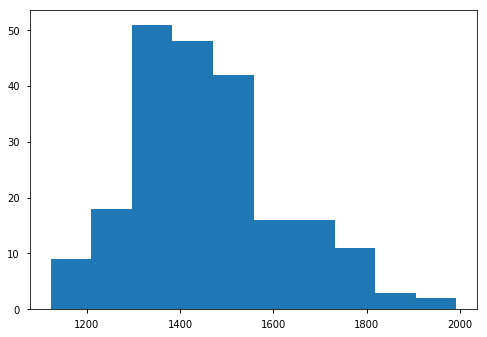

In [56]:
plt.hist(X_eTIV)

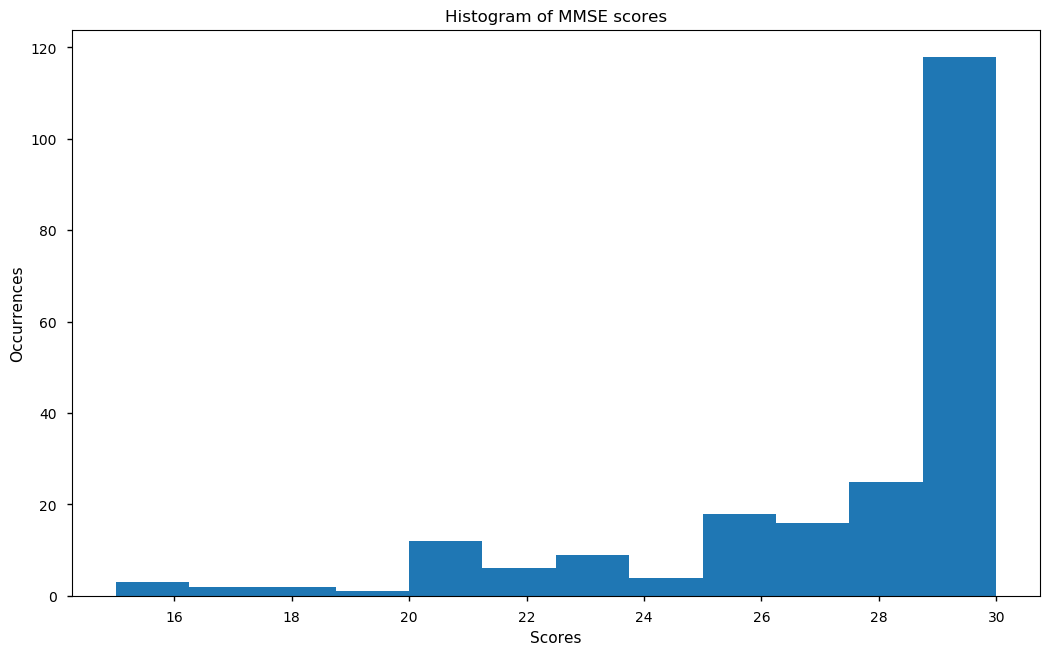

In [65]:
plt.figure(1, figsize=(12.5, 7.5), dpi=100)

hist = plt.hist(Y_MMSE, bins='auto')
plt.title('Histogram of MMSE scores')
plt.xlabel('Scores')
plt.ylabel('Occurrences')
plt.show()

# Analysis

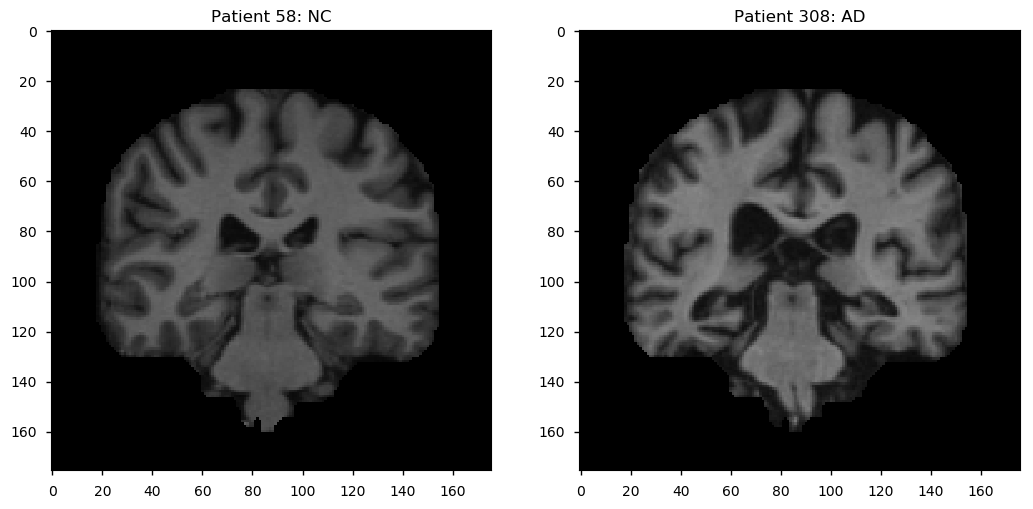

In [9]:
plt.figure(1, figsize=(12.5, 7.5), dpi=100)
plt.subplot(121)
plt.imshow(cv2.imread("{}".format(coronal90loc[HealthyExampleIndex])))
plt.title("Patient 58: NC")
plt.subplot(122)
plt.title("Patient 308: AD")
plt.imshow(cv2.imread("{}".format(coronal90loc[SickExampleIndex]))) 
plt.show()

Original scans of the example patients.

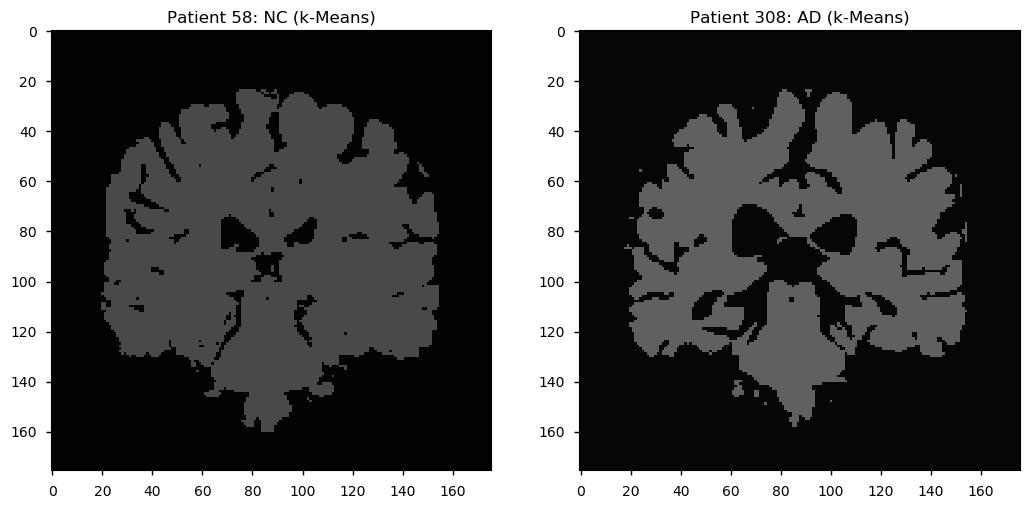

In [186]:

plt.figure(2, figsize=(12.5, 7.5), dpi=100)

plt.subplot(121)
plt.imshow(coronal90_tensor[HealthyExampleIndex])
plt.title("Patient 58: NC (k-Means)")

plt.subplot(122)
plt.imshow(coronal90_tensor[SickExampleIndex], cmap='spring')
plt.title("Patient 308: AD (k-Means)")

plt.show()

In [11]:
patient_holder = np.concatenate((coronal90_tensor,
                                 coronal91_tensor,
                                 coronal92_tensor,
                                 coronal93_tensor,
                                 coronal94_tensor,
                                 coronal95_tensor,
                                 coronal96_tensor,
                                 coronal97_tensor,
                                 coronal98_tensor,
                                 coronal99_tensor))
print(patient_holder.shape)

fin_Y_CDR_encoded = np.tile(Y_CDR_encoded, [10,1])

print(fin_Y_CDR_encoded.shape)

(2160, 176, 176, 3)
(2160, 2)


Scans after post processing.

In [46]:
train_percentage_as_decimal = 0.70
end = round(train_percentage_as_decimal*patient_holder.shape[0])
print(end)

X_train_tensor = patient_holder[0:end]
Y_train_output = fin_Y_CDR_encoded[0:end]
X_test_tensor = patient_holder[end:patient_holder.shape[0]]
Y_test_output = fin_Y_CDR_encoded[end:patient_holder.shape[0]]

print(Y_train_output.shape)
print("{}% of the training sample has No Condition".format((100*Y_train_output[:,0].sum()/Y_train_output.shape[0])))
print("{}% of the training sample has Alzheimer's Disease".format((100*Y_train_output[:,1].sum()/Y_train_output.shape[0])))
print(Y_test_output.shape)
print("{}% of the validation testing sample has No Condition".format((100*Y_test_output[:,0].sum()/Y_test_output.shape[0])))
print("{}% of the validation testing sample has Alzheimer's Disease".format((100*Y_test_output[:,1].sum()/Y_test_output.shape[0])))

1512
(1512, 2)
61.574074074074076% of the training sample has No Condition
38.425925925925924% of the training sample has Alzheimer's Disease
(648, 2)
61.574074074074076% of the validation testing sample has No Condition
38.425925925925924% of the validation testing sample has Alzheimer's Disease


In [13]:
import keras 
import tensorflow as tf
from keras import backend as K


print('Keras: ', keras.__version__, 'Tensorflow: ', tf.__version__)
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


Keras:  2.1.4 Tensorflow:  1.1.0


['/gpu:0']

In [14]:
from keras import Sequential
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dropout, Dense

model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(176,176,3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(1028, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1028, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
               optimizer='sgd',
               metrics=['categorical_accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 178, 178, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 176, 176, 64)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 178, 178, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 176, 176, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 88, 88, 64)        0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 90, 90, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 88, 88, 128)       73856     
__________

In [19]:
normhistory = model.fit(X_train_tensor, Y_train_output,
                        batch_size=32,
                        epochs=150,
                        verbose=1,
                        shuffle=True,
                        validation_data=(X_test_tensor, Y_test_output))

score = model.evaluate(X_test_tensor, Y_test_output)

print('\nTest loss:', score[0])
print('\nTest accuracy:', score[1])

Train on 1512 samples, validate on 648 samples
Epoch 1/150
1512/1512 [==============================] - 108s 71ms/step - loss: 0.6685 - categorical_accuracy: 0.6157 - val_loss: 0.6667 - val_categorical_accuracy: 0.6157
Epoch 2/150
1512/1512 [==============================] - 108s 71ms/step - loss: 0.6672 - categorical_accuracy: 0.6157 - val_loss: 0.6663 - val_categorical_accuracy: 0.6157
Epoch 3/150
1512/1512 [==============================] - 110s 73ms/step - loss: 0.6669 - categorical_accuracy: 0.6157 - val_loss: 0.6661 - val_categorical_accuracy: 0.6157
Epoch 4/150
1512/1512 [==============================] - 109s 72ms/step - loss: 0.6660 - categorical_accuracy: 0.6157 - val_loss: 0.6661 - val_categorical_accuracy: 0.6157
Epoch 5/150
1512/1512 [==============================] - 109s 72ms/step - loss: 0.6664 - categorical_accuracy: 0.6157 - val_loss: 0.6661 - val_categorical_accuracy: 0.6157
Epoch 6/150
1512/1512 [==============================] - 110s 73ms/step - loss: 0.6665 - cate

1512/1512 [==============================] - 115s 76ms/step - loss: 0.6657 - categorical_accuracy: 0.6157 - val_loss: 0.6654 - val_categorical_accuracy: 0.6157
Epoch 49/150
1512/1512 [==============================] - 115s 76ms/step - loss: 0.6657 - categorical_accuracy: 0.6157 - val_loss: 0.6653 - val_categorical_accuracy: 0.6157
Epoch 50/150
1512/1512 [==============================] - 115s 76ms/step - loss: 0.6653 - categorical_accuracy: 0.6157 - val_loss: 0.6653 - val_categorical_accuracy: 0.6157
Epoch 51/150
1512/1512 [==============================] - 115s 76ms/step - loss: 0.6656 - categorical_accuracy: 0.6157 - val_loss: 0.6657 - val_categorical_accuracy: 0.6157
Epoch 52/150
1512/1512 [==============================] - 115s 76ms/step - loss: 0.6662 - categorical_accuracy: 0.6157 - val_loss: 0.6657 - val_categorical_accuracy: 0.6157
Epoch 53/150
1512/1512 [==============================] - 115s 76ms/step - loss: 0.6658 - categorical_accuracy: 0.6157 - val_loss: 0.6652 - val_cate

1512/1512 [==============================] - 119s 79ms/step - loss: 0.5346 - categorical_accuracy: 0.7249 - val_loss: 0.5826 - val_categorical_accuracy: 0.6944
Epoch 96/150
1512/1512 [==============================] - 119s 79ms/step - loss: 0.5404 - categorical_accuracy: 0.7169 - val_loss: 0.5440 - val_categorical_accuracy: 0.6667
Epoch 97/150
1512/1512 [==============================] - 120s 79ms/step - loss: 0.5196 - categorical_accuracy: 0.7255 - val_loss: 0.7836 - val_categorical_accuracy: 0.3873
Epoch 98/150
1512/1512 [==============================] - 120s 80ms/step - loss: 0.5333 - categorical_accuracy: 0.7136 - val_loss: 0.5103 - val_categorical_accuracy: 0.7392
Epoch 99/150
1512/1512 [==============================] - 122s 81ms/step - loss: 0.5185 - categorical_accuracy: 0.7308 - val_loss: 0.5789 - val_categorical_accuracy: 0.6775
Epoch 100/150
1512/1512 [==============================] - 120s 79ms/step - loss: 0.5101 - categorical_accuracy: 0.7388 - val_loss: 0.6114 - val_cat

1512/1512 [==============================] - 120s 80ms/step - loss: 0.1093 - categorical_accuracy: 0.9563 - val_loss: 0.5557 - val_categorical_accuracy: 0.8256
Epoch 143/150
1512/1512 [==============================] - 120s 79ms/step - loss: 0.0140 - categorical_accuracy: 0.9974 - val_loss: 0.7606 - val_categorical_accuracy: 0.8102
Epoch 144/150
1512/1512 [==============================] - 121s 80ms/step - loss: 0.0052 - categorical_accuracy: 1.0000 - val_loss: 0.6687 - val_categorical_accuracy: 0.8364
Epoch 145/150
1512/1512 [==============================] - 124s 82ms/step - loss: 0.0026 - categorical_accuracy: 1.0000 - val_loss: 0.7593 - val_categorical_accuracy: 0.8364
Epoch 146/150
1512/1512 [==============================] - 122s 81ms/step - loss: 0.0019 - categorical_accuracy: 1.0000 - val_loss: 0.7677 - val_categorical_accuracy: 0.8380
Epoch 147/150
1512/1512 [==============================] - 121s 80ms/step - loss: 0.0401 - categorical_accuracy: 0.9861 - val_loss: 0.7027 - val

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy'])


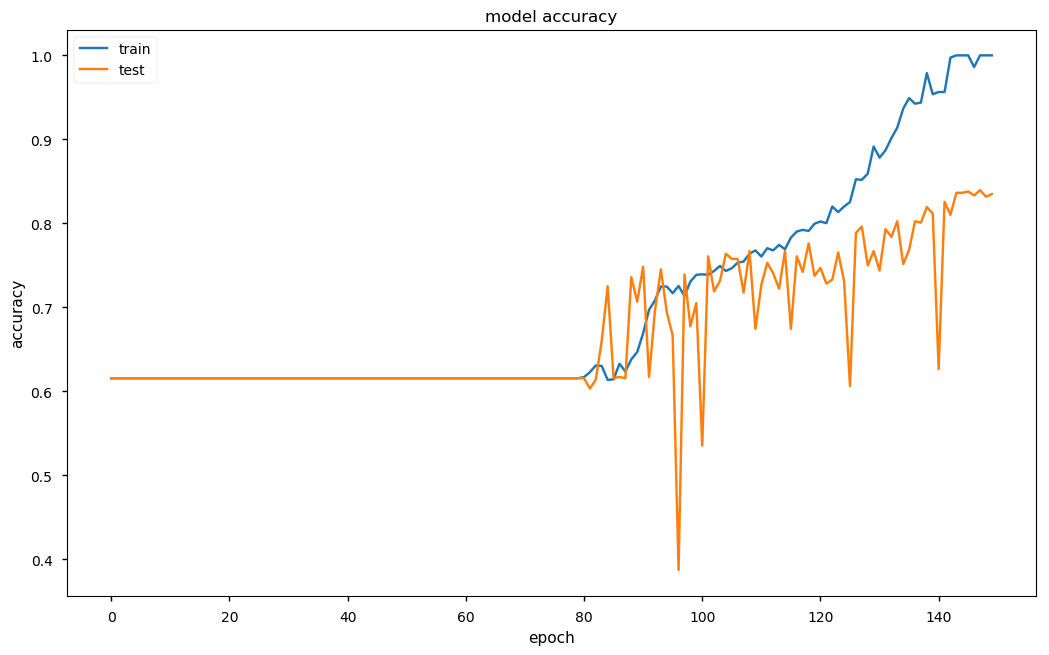

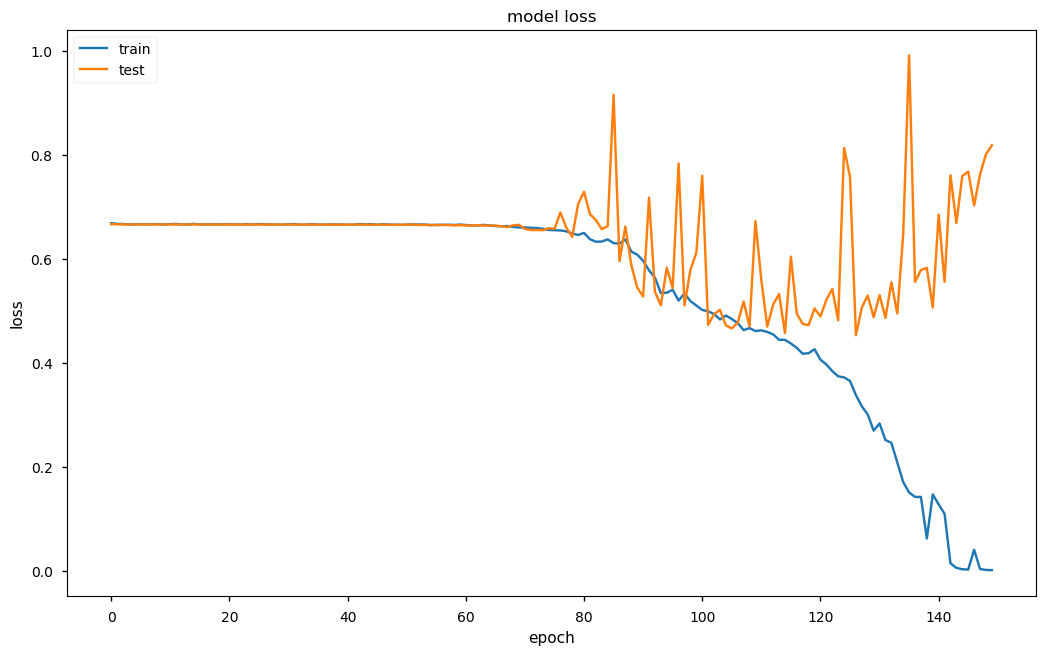

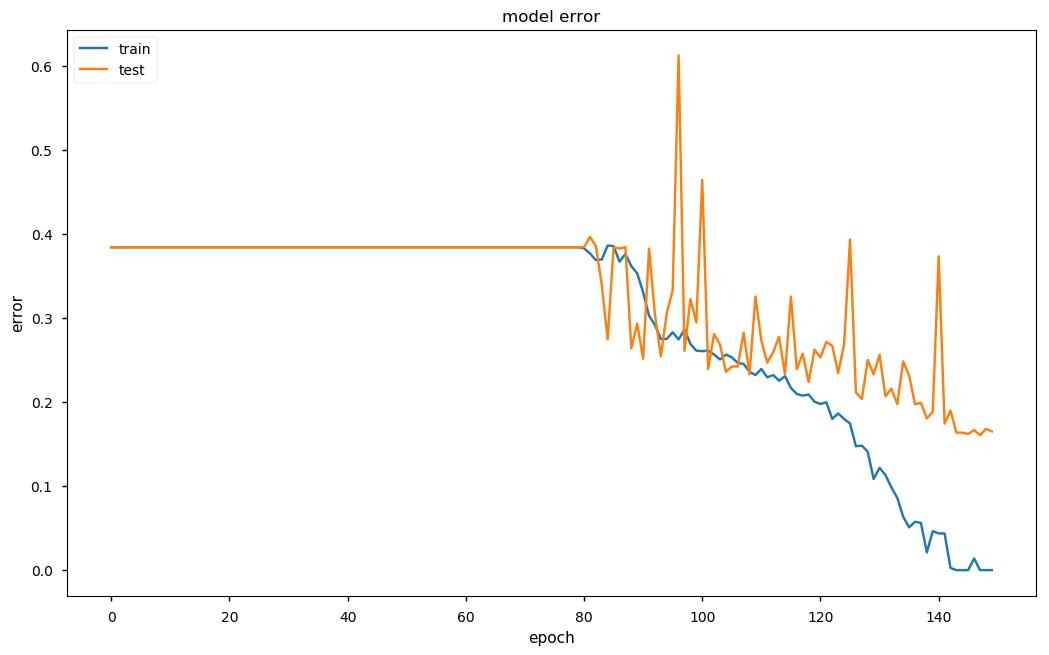

In [47]:
# list all data in history
print(normhistory.history.keys())
plt.figure(3, figsize=(12.5, 7.5), dpi=100)
# summarize history for accuracy
caterror = [1-x for x in normhistory.history['categorical_accuracy']]
valcaterror = [1-x for x in normhistory.history['val_categorical_accuracy']]
plt.plot(normhistory.history['categorical_accuracy'])
plt.plot(normhistory.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(3, figsize=(12.5, 7.5), dpi=100)
plt.plot(normhistory.history['loss'])
plt.plot(normhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.figure(3, figsize=(12.5, 7.5), dpi=100)
plt.plot(caterror)
plt.plot(valcaterror)
plt.title('model error')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [192]:
print(caterror.index(min(caterror)))
print(valcaterror.index(min(valcaterror)))
print(np.std(caterror))
print(np.mean(caterror))
print(np.std(valcaterror))
print(np.mean(valcaterror))

143
147
0.123208333781
0.29667989418
0.0795510639525
0.330411522634


In [37]:
from keras import backend as K

# with a Sequential model
dshfLKvhSLDKjv = K.function([model.layers[0].input],
                                  [model.layers[1].output])

example1 = np.reshape([X_train_tensor[HealthyExampleIndex]], (1,176,176,3))
example2 = np.reshape([X_train_tensor[SickExampleIndex]], (1,176,176,3))

hactivations2 = np.squeeze(np.asarray(dshfLKvhSLDKjv([example1])))
sactivations2 = np.squeeze(np.asarray(dshfLKvhSLDKjv([example2])))

print(hactivations2.shape)
print(sactivations2.shape)


healthy_activations2 = np.moveaxis(hactivations2, -1, 0)
sick_activations2 = np.moveaxis(sactivations2, -1, 0)

(176, 176, 64)
(176, 176, 64)


C:\Users\Shak3\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


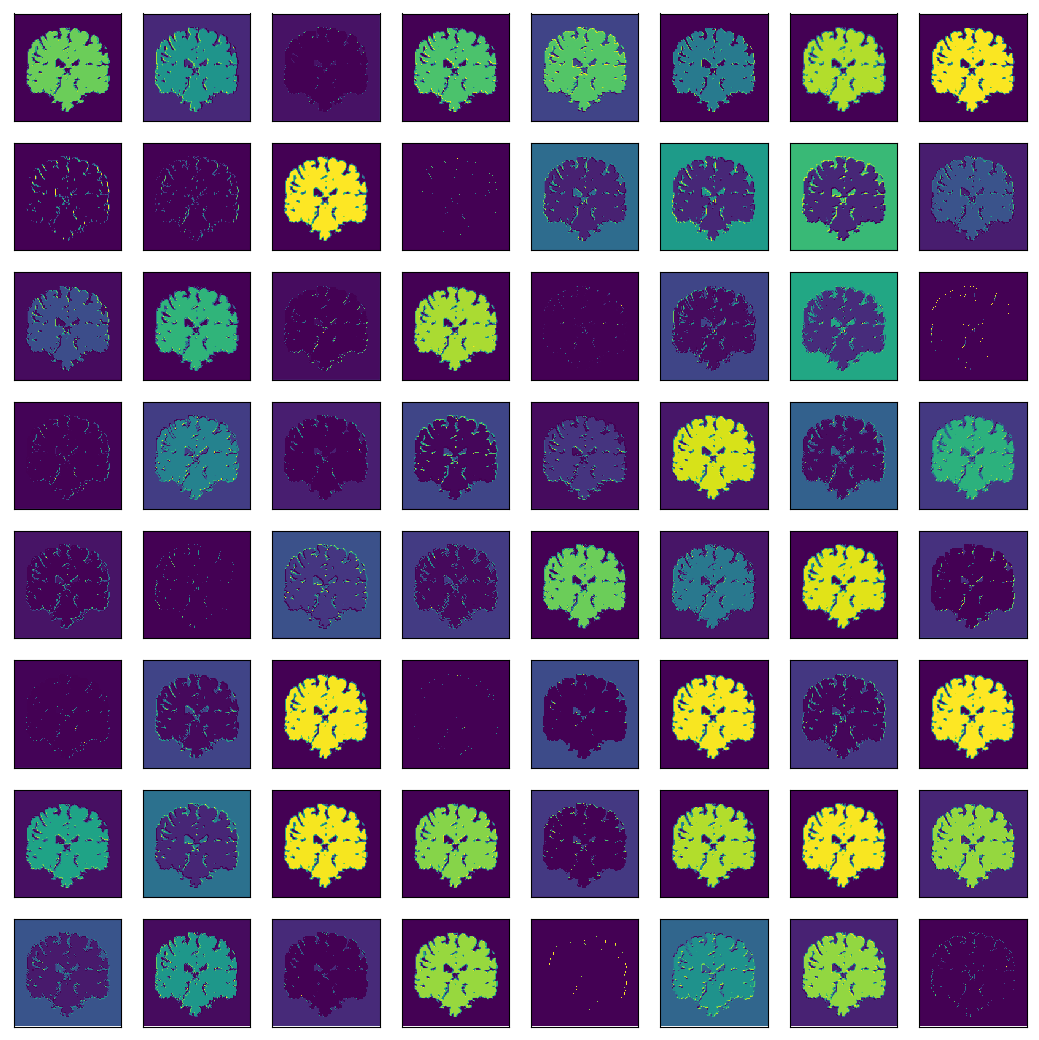

In [38]:
plt.figure(3, figsize=(10.5, 10.5), dpi=100)

for i in range(64):
    plt.subplot(8,8,(i+1))
    plt.imshow(healthy_activations2[i])
    plt.tick_params(
        axis='both',       # changes apply to the both
        which='both',      # both major and minor ticks are affected
        bottom='off',      
        top='off',         # ticks along the edges are off
        left='off',
        right='off',
        labelbottom='off', 
        labeltop='off', 
        labelleft='off', 
        labelright='off')  # labels along the edges are off
    plt.tight_layout()


plt.show()

C:\Users\Shak3\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


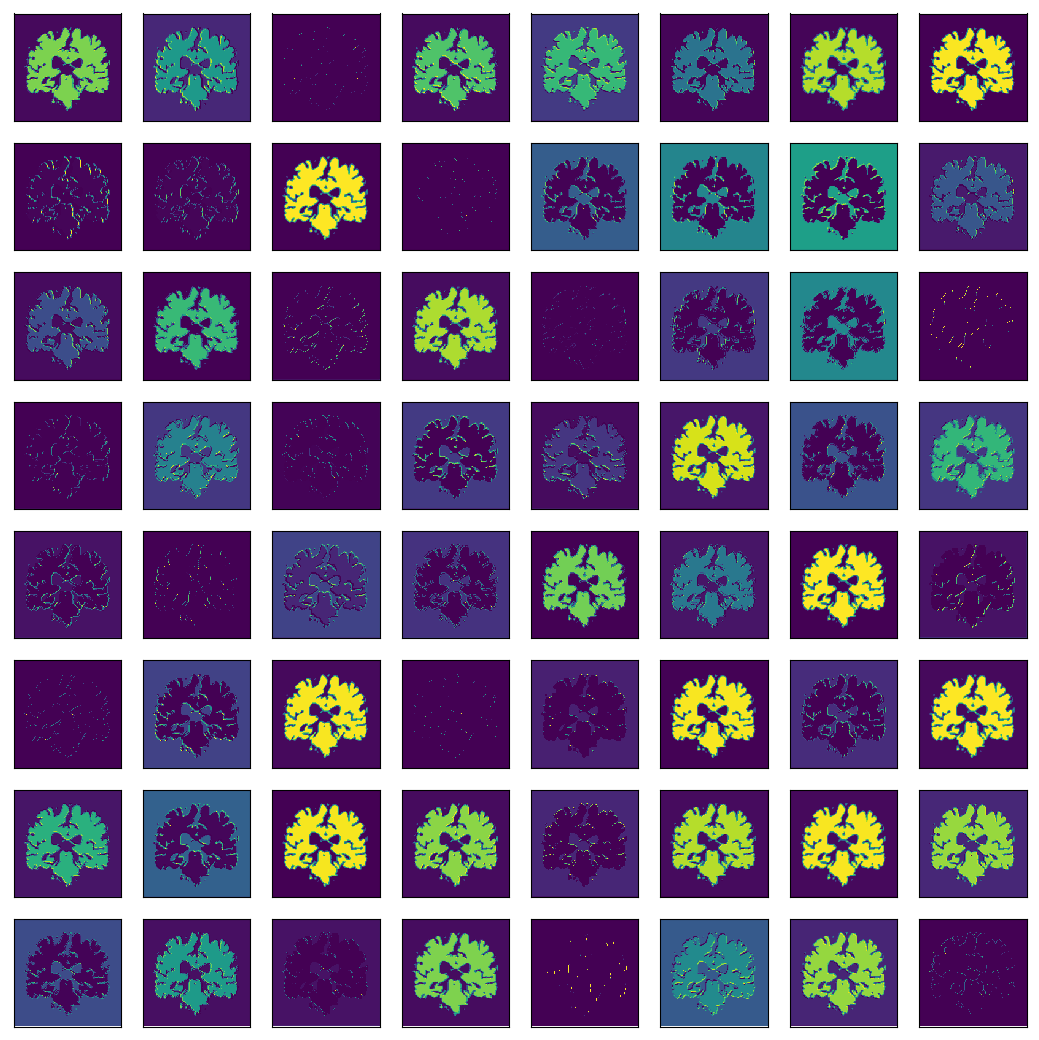

In [39]:
plt.figure(3, figsize=(10.5, 10.5), dpi=100)

for i in range(64):
    plt.subplot(8,8,(i+1))
    plt.imshow(sick_activations2[i])
    plt.tick_params(
        axis='both',       # changes apply to the both
        which='both',      # both major and minor ticks are affected
        bottom='off',      
        top='off',         # ticks along the edges are off
        left='off',
        right='off',
        labelbottom='off', 
        labeltop='off', 
        labelleft='off', 
        labelright='off')  # labels along the edges are off
    plt.tight_layout()

plt.show()

In [41]:
faudshf = K.function([model.layers[0].input], 
                     [model.layers[2].output])


hactivations3 = np.squeeze(np.asarray(faudshf([example1])))
sactivations3 = np.squeeze(np.asarray(faudshf([example2])))

print(hactivations3.shape)
print(sactivations3.shape)


healthy_activations3 = np.moveaxis(hactivations3, -1, 0)
sick_activations3 = np.moveaxis(sactivations3, -1, 0)

(178, 178, 64)
(178, 178, 64)


C:\Users\Shak3\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


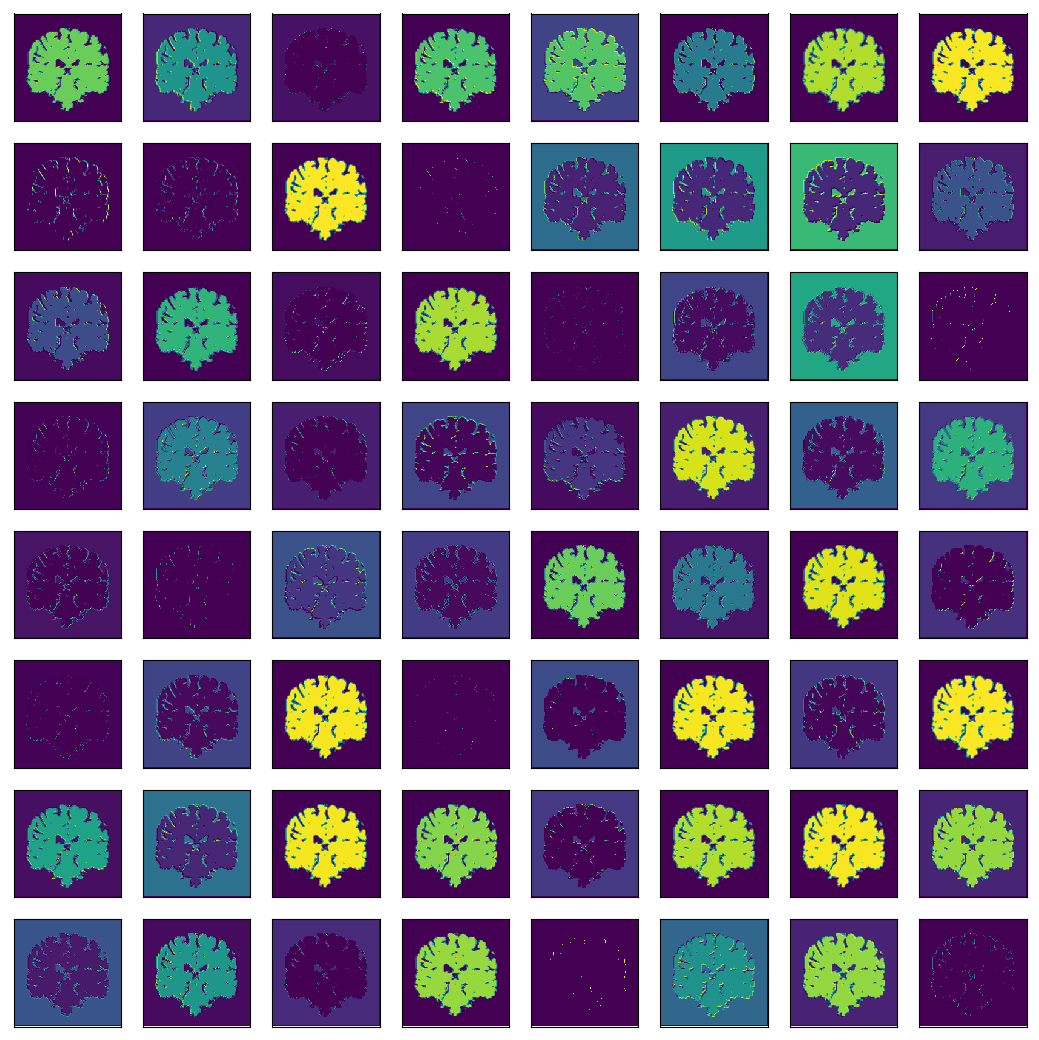

In [44]:
plt.figure(3, figsize=(10.5, 10.5), dpi=100)

for i in range(64):
    plt.subplot(8,8,(i+1))
    plt.imshow(healthy_activations3[i])
    plt.tick_params(
        axis='both',       # changes apply to the both
        which='both',      # both major and minor ticks are affected
        bottom='off',      
        top='off',         # ticks along the edges are off
        left='off',
        right='off',
        labelbottom='off', 
        labeltop='off', 
        labelleft='off', 
        labelright='off')  # labels along the edges are off
    plt.tight_layout()

plt.show()

C:\Users\Shak3\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


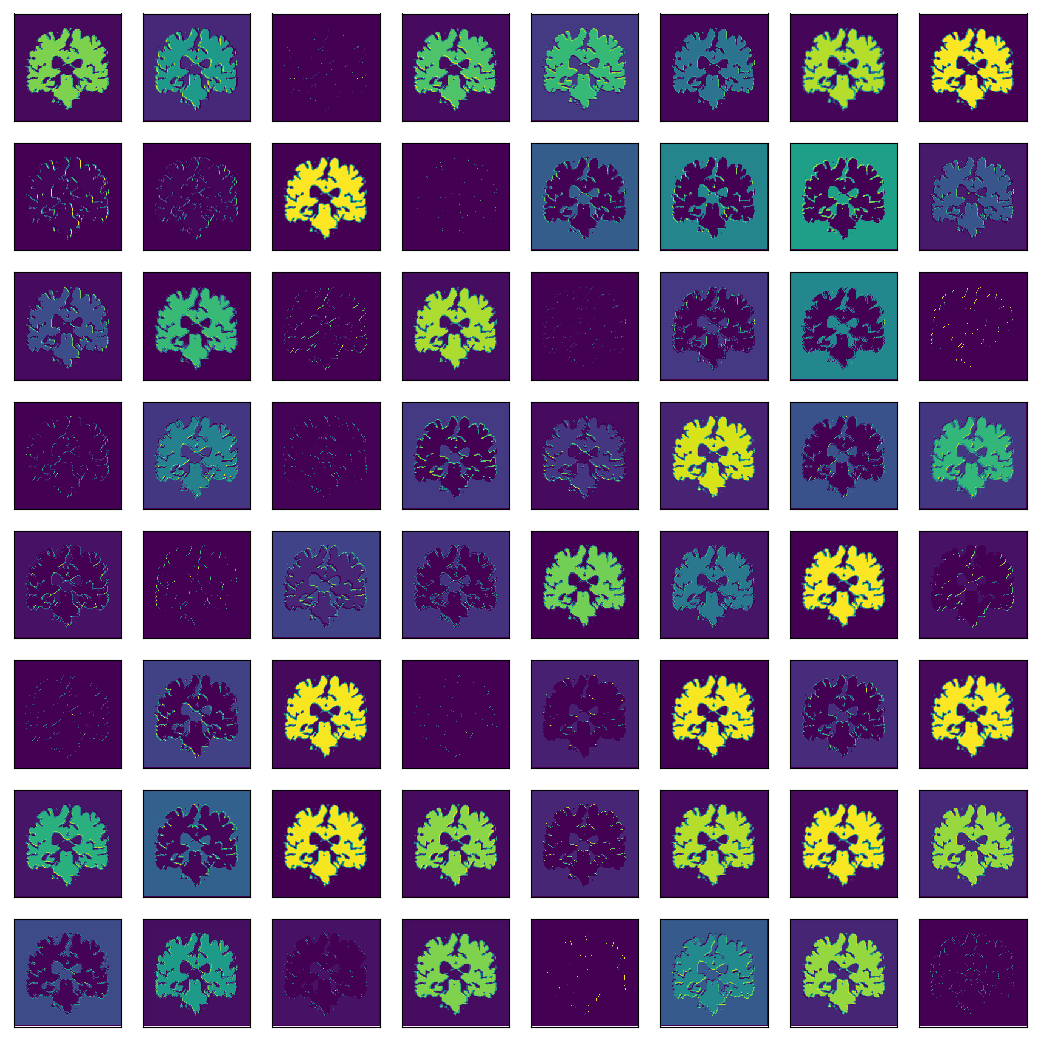

In [45]:
plt.figure(3, figsize=(10.5, 10.5), dpi=100)

for i in range(64):
    plt.subplot(8,8,(i+1))
    plt.imshow(sick_activations3[i])
    plt.tick_params(
        axis='both',       # changes apply to the both
        which='both',      # both major and minor ticks are affected
        bottom='off',      
        top='off',         # ticks along the edges are off
        left='off',
        right='off',
        labelbottom='off', 
        labeltop='off', 
        labelleft='off', 
        labelright='off')  # labels along the edges are off
    plt.tight_layout()

plt.show()

In [151]:
valssdfjs = np.flip(hist[1], axis=0)
valssdfjs[0]=29.99999
print(valssdfjs)

results = (model.predict(coronal90_tensor)).round()

TPholder = []
TNholder = []
FPholder = []
FNholder = []
FPRholder = []
TPRholder = []

for threshold in valssdfjs:
    print(threshold)
    TP=0
    TN=0
    FP=0
    FN=0
    Y_MMSE_tmp_bin=[] 
    for i in range(len(Y_MMSE)):
        if Y_MMSE[i]>threshold:
            Y_MMSE_tmp_bin.append([1,0])
        elif Y_MMSE[i]<=threshold:
            Y_MMSE_tmp_bin.append([0,1])
        if results[i][0] == 1 and Y_MMSE_tmp_bin[-1][0] == 1:
            TN+=1
        elif results[i][1] == 1 and Y_MMSE_tmp_bin[-1][1] == 1:
            TP+=1
        elif results[i][0] == 1 and Y_MMSE_tmp_bin[-1][1] == 1:
            FN+=1
        elif results[i][1] == 1 and Y_MMSE_tmp_bin[-1][0] == 1:
            FP+=1
    FPR = FP/(FP+TN)
    TPR = TP/(TP+FN)
    TPholder.append(TP)
    TNholder.append(TN)
    FPholder.append(FP)
    FNholder.append(FN)
    FPRholder.append(FPR)
    TPRholder.append(TPR)
FPRholder.append(1)
TPRholder.append(1)
FPRholder = np.asarray(FPRholder)
TPRholder = np.asarray(TPRholder)
FPRholder = np.insert(FPRholder, 0 , 0)
TPRholder = np.insert(TPRholder, 0 , 0)

[ 29.99999  28.75     27.5      26.25     25.       23.75     22.5      21.25
  20.       18.75     17.5      16.25     15.     ]
29.99999
28.75
27.5
26.25
25.0
23.75
22.5
21.25
20.0
18.75
17.5
16.25
15.0


(15,)
15
area = 0.904347868899


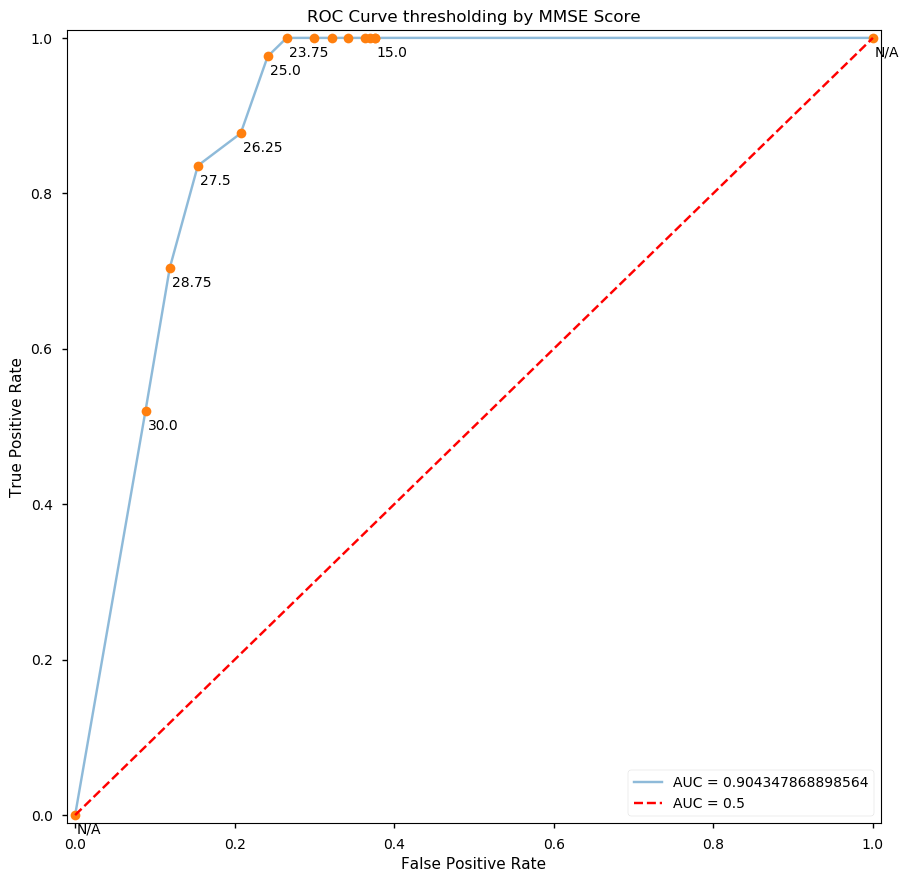

In [183]:
labels=['N/A', 30.0, 28.75, 27.5, 26.25, 25.0, 23.75, ' ', ' ', ' ', ' ', ' ', ' ', 15.0, 'N/A']
print(FPRholder.shape)
print(len(labels))

from numpy import trapz
area = trapz(TPRholder, FPRholder)
print("area =", area)

plt.figure(3, figsize=(10.5, 10.5), dpi=100)
plt.plot(FPRholder,TPRholder, alpha=0.5, label='AUC = {}'.format(area))
plt.plot(FPRholder,TPRholder, 'o')
plt.plot(FPRholder,FPRholder, 'r--', label='AUC = 0.5')
for i, txt in enumerate(labels):
    if txt==' ':
        continue
    plt.annotate(txt, xy=(FPRholder[i],TPRholder[i]),
                 xytext=(FPRholder[i]+0.0025,TPRholder[i]-0.024))
plt.xlim(-0.01,1.01)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim(-0.01,1.01)
plt.title('ROC Curve thresholding by MMSE Score')
plt.legend()
plt.show()

In [ ]:
def auto_canny(image):
    imagef = np.ndarray.flatten(image)
    # compute the mean of the single channel pixel intensities
    m = np.mean(imagef)
    s = np.std(imagef)
 
    # apply automatic Canny edge detection using the computed mean
    lower = int(max(np.min(imagef), m-2*s))
    upper = int(min(np.max(imagef), m+2*s))
    edged = cv2.Canny(image, lower, upper, apertureSize=3, L2gradient=True)
 
    # return the edged image
    return edged

In [ ]:
healthyIMAGE = cv2.imread("{}".format(coronal90loc[HealthyExampleIndex]))
sickIMAGE = cv2.imread("{}".format(coronal90loc[SickExampleIndex]))

plt.figure(3, figsize=(10.5, 7.5), dpi=100)

plt.subplot(121)
plt.imshow(auto_canny(healthyIMAGE), cmap='binary')
plt.tight_layout()
plt.title("Patient 58: NC (Canny Edge Detection)")

plt.subplot(122)
plt.imshow(auto_canny(sickIMAGE), cmap='binary')
plt.tight_layout()
plt.title("Patient 308: AD (Canny Edge Detection)")


plt.show()

In [ ]:
def cannyprepPNGimgs(array_of_image_paths):
    l = []
    for img_file in array_of_image_paths: # for each file in the list of images...
        img = cv2.imread("{}".format(img_file)) # read the image...
        img = auto_canny(img) # new canny processing
        gray_scaled = (np.divide(img, np.amax(img))) # and scale the image.
        l.append(gray_scaled)
    
    return(np.asarray(l))

cannycoronal90_tensor = cannyprepPNGimgs(coronal90loc)
cannycoronal91_tensor = cannyprepPNGimgs(coronal91loc)
cannycoronal92_tensor = cannyprepPNGimgs(coronal92loc)
cannycoronal93_tensor = cannyprepPNGimgs(coronal93loc)
cannycoronal94_tensor = cannyprepPNGimgs(coronal94loc)
cannycoronal95_tensor = cannyprepPNGimgs(coronal95loc)
cannycoronal96_tensor = cannyprepPNGimgs(coronal96loc)
cannycoronal97_tensor = cannyprepPNGimgs(coronal97loc)
cannycoronal98_tensor = cannyprepPNGimgs(coronal98loc)
cannycoronal99_tensor = cannyprepPNGimgs(coronal99loc)

In [ ]:
cannypatient_holder = []

for i in range(0,216):
    #print("concatenating patient {}".format(i))
    cannyone_patient = [cannycoronal90_tensor[i],
                  cannycoronal91_tensor[i],
                  cannycoronal92_tensor[i],
                  cannycoronal93_tensor[i],
                  cannycoronal94_tensor[i],
                  cannycoronal95_tensor[i],
                  cannycoronal96_tensor[i],
                  cannycoronal97_tensor[i],
                  cannycoronal98_tensor[i],
                  cannycoronal99_tensor[i]]
    cannyone_patient = np.asarray(cannyone_patient)
    cannyone_patient = np.moveaxis(cannyone_patient, 0, -1)
    cannypatient_holder.append(cannyone_patient)
    
cannypatient_holder = np.asarray(cannypatient_holder)

plt.figure(3, figsize=(12.5, 7.5), dpi=100)

plt.subplot(121)
plt.imshow(cannycoronal90_tensor[HealthyExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(cannycoronal91_tensor[HealthyExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(cannycoronal92_tensor[HealthyExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(cannycoronal93_tensor[HealthyExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(cannycoronal94_tensor[HealthyExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(cannycoronal95_tensor[HealthyExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(cannycoronal96_tensor[HealthyExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(cannycoronal97_tensor[HealthyExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(cannycoronal98_tensor[HealthyExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(cannycoronal99_tensor[HealthyExampleIndex], cmap='spring', alpha=0.1)
plt.colorbar(orientation='vertical', shrink=0.6)
plt.title("Patient 58: NC (Canny Edge Detection)")

plt.subplot(122)
plt.imshow(cannycoronal90_tensor[SickExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(cannycoronal91_tensor[SickExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(cannycoronal92_tensor[SickExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(cannycoronal93_tensor[SickExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(cannycoronal94_tensor[SickExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(cannycoronal95_tensor[SickExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(cannycoronal96_tensor[SickExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(cannycoronal97_tensor[SickExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(cannycoronal98_tensor[SickExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(cannycoronal99_tensor[SickExampleIndex], cmap='spring', alpha=0.1)
plt.colorbar(orientation='vertical', shrink=0.6)
plt.title("Patient 308: AD (Canny Edge Detection)")

plt.show()

In [ ]:
cannyX_train_tensor = cannypatient_holder[0:end]
cannyX_test_tensor = cannypatient_holder[end:patient_holder.shape[0]]

print(Y_train_output.shape)
print("{}% of the training sample has No Condition".format((100*Y_train_output[:,0].sum()/Y_train_output.shape[0])))
print("{}% of the training sample has Alzheimer's Disease".format((100*Y_train_output[:,1].sum()/Y_train_output.shape[0])))
print(Y_test_output.shape)
print("{}% of the validation testing sample has No Condition".format((100*Y_test_output[:,0].sum()/Y_test_output.shape[0])))
print("{}% of the validation testing sample has Alzheimer's Disease".format((100*Y_test_output[:,1].sum()/Y_test_output.shape[0])))

In [ ]:
cannybad_model = Sequential()
cannybad_model.add(Flatten(input_shape=(176,176,10)))
cannybad_model.add(Dense(2, activation='sigmoid'))
cannybad_model.summary()
cannybad_model.compile(loss='categorical_crossentropy',
               optimizer='sgd',
               metrics=['categorical_accuracy'])
cannybad_model.fit(cannyX_train_tensor, Y_train_output, epochs=5)

In [ ]:
cannybad_model.evaluate(cannyX_test_tensor, Y_test_output)

In [ ]:
cannymodel = Sequential()
cannymodel.add(Convolution2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=(176,176,10)))
cannymodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cannymodel.add(Convolution2D(64, (5, 5), activation='relu'))
cannymodel.add(MaxPooling2D(pool_size=(2, 2)))
cannymodel.add(Flatten())
cannymodel.add(Dense(1000, activation='relu'))
cannymodel.add(Dense(2, activation='softmax'))

opt = Adam(lr=1e-6)

cannymodel.compile(loss='categorical_crossentropy',
               optimizer='sgd',
               metrics=['categorical_accuracy'])


cannyhistory = cannymodel.fit(cannyX_train_tensor, Y_train_output,
          batch_size=32,
          epochs=40,
          verbose=1,
          shuffle=True,
          validation_data=(cannyX_test_tensor, Y_test_output))

score = cannymodel.evaluate(cannyX_test_tensor, Y_test_output)

print('\nTest loss:', score[0])
print('\nTest accuracy:', score[1])

In [ ]:
# list all data in history
print(normhistory.history.keys())
# summarize history for accuracy
plt.figure(3, figsize=(12.5, 7.5), dpi=100)

plt.plot(cannyhistory.history['categorical_accuracy'])
plt.plot(cannyhistory.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(3, figsize=(12.5, 7.5), dpi=100)

plt.plot(cannyhistory.history['loss'])
plt.plot(cannyhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
uschdcsudco = K.function([cannymodel.layers[0].input],
                         [cannymodel.layers[0].output])


cannyactivations2 = np.squeeze(np.asarray(uschdcsudco([cannyX_train_tensor])))
print(cannyactivations2.shape)

print(cannyactivations2[HealthyExampleIndex].shape)
print(cannyactivations2[SickExampleIndex].shape)

cannyhealthy_activations2 = np.moveaxis(cannyactivations2[HealthyExampleIndex], -1, 0)
cannysick_activations2 = np.moveaxis(cannyactivations2[SickExampleIndex], -1, 0)

In [ ]:
plt.figure(3, figsize=(10.5, 10.5), dpi=100)

for i in range(32):
    plt.subplot(6,6,(i+1))
    plt.imshow(cannyhealthy_activations2[i], cmap='spring')
    plt.tick_params(
        axis='both',       # changes apply to the both
        which='both',      # both major and minor ticks are affected
        bottom='off',      
        top='off',         # ticks along the edges are off
        left='off',
        right='off',
        labelbottom='off', 
        labeltop='off', 
        labelleft='off', 
        labelright='off')  # labels along the edges are off
    plt.tight_layout()


plt.show()

In [ ]:
plt.figure(3, figsize=(10.5, 10.5), dpi=100)

for i in range(32):
    plt.subplot(6,6,(i+1))
    plt.imshow(cannysick_activations2[i], cmap='spring')
    plt.tick_params(
        axis='both',       # changes apply to the both
        which='both',      # both major and minor ticks are affected
        bottom='off',      
        top='off',         # ticks along the edges are off
        left='off',
        right='off',
        labelbottom='off', 
        labeltop='off', 
        labelleft='off', 
        labelright='off')  # labels along the edges are off
    plt.tight_layout()

plt.show()

In [ ]:
fhsldjkfhaljskfhal = K.function([model.layers[0].input],
                            [model.layers[2].output])


cannyactivations3 = np.squeeze(np.asarray(fhsldjkfhaljskfhal([cannyX_train_tensor])))
print(cannyactivations3.shape)

print(cannyactivations3[HealthyExampleIndex].shape)
print(cannyactivations3[SickExampleIndex].shape)

cannyhealthy_activations3 = np.moveaxis(cannyactivations3[HealthyExampleIndex], -1, 0)
cannysick_activations3 = np.moveaxis(cannyactivations3[SickExampleIndex], -1, 0)

In [ ]:
plt.figure(3, figsize=(10.5, 10.5), dpi=100)

for i in range(64):
    plt.subplot(8,8,(i+1))
    plt.imshow(cannyhealthy_activations3[i], cmap='spring')
    plt.tick_params(
        axis='both',       # changes apply to the both
        which='both',      # both major and minor ticks are affected
        bottom='off',      
        top='off',         # ticks along the edges are off
        left='off',
        right='off',
        labelbottom='off', 
        labeltop='off', 
        labelleft='off', 
        labelright='off')  # labels along the edges are off
    plt.tight_layout()

plt.show()

In [ ]:
plt.figure(3, figsize=(10.5, 10.5), dpi=100)

for i in range(64):
    plt.subplot(8,8,(i+1))
    plt.imshow(cannysick_activations3[i], cmap='spring')
    plt.tick_params(
        axis='both',       # changes apply to the both
        which='both',      # both major and minor ticks are affected
        bottom='off',      
        top='off',         # ticks along the edges are off
        left='off',
        right='off',
        labelbottom='off', 
        labeltop='off', 
        labelleft='off', 
        labelright='off')  # labels along the edges are off
    plt.tight_layout()

plt.show()

In [ ]:
def edgesMarrHildreth(img, sigma):
    """
        finds the edges using Marr Hildreth edge detection method...
        :param im : input image
        :param sigma : sigma is the std-deviation and refers to the spread of gaussian
        :return:
    a binary edge image...
    """
    size = int(2*(np.ceil(3*sigma))+1)

    x, y = np.meshgrid(np.arange(-size/2+1, size/2+1), np.arange(-size/2+1, size/2+1))
    
    normal = 1 / (2.0 * np.pi * sigma**2)
    kernel = ((x**2 + y**2 - (2.0*sigma**2)) / sigma**4) * np.exp(-(x**2+y**2) / (2.0*sigma**2)) / normal # LoG filter

    kern_size = kernel.shape[0]
    log = np.zeros_like(img, dtype=float)

    # applying filter
    for i in range(img.shape[0]-(kern_size-1)):
        for j in range(img.shape[1]-(kern_size-1)):
            window = img[i:i+kern_size, j:j+kern_size] * kernel
            log[i,j] = np.sum(window)

    log = log.astype(np.int64, copy=False)

    zero_crossing = np.zeros_like(log)

    # computing zero crossing
    for i in range(log.shape[0]-(kern_size-1)):
        for j in range(log.shape[1]-(kern_size-1)):
            if log[i][j] == 0:
                if (log[i][j-1] < 0 and log[i][j+1] > 0) or (log[i][j-1] < 0 and log[i][j+1] < 0) or (log[i-1][j] < 0 and log[i+1][j] > 0) or (log[i-1][j] > 0 and log[i+1][j] < 0):
                    zero_crossing[i][j] = 255
            elif log[i][j] < 0:
                if (log[i][j-1] > 0) or (log[i][j+1] > 0) or (log[i-1][j] > 0) or (log[i+1][j] > 0):
                    zero_crossing[i][j] = 255

    hzeroes = np.reshape(np.zeros(zero_crossing.shape[0]), newshape=(176,1))
    vzeroes = np.reshape(np.zeros(zero_crossing.shape[0]), newshape=(1,176))
    for i in range(10):
        zero_crossing = np.hstack((hzeroes,zero_crossing))
        zero_crossing = np.delete(zero_crossing, -1, axis=1)
    for i in range(10):
        zero_crossing = np.vstack((vzeroes,zero_crossing))
        zero_crossing = np.delete(zero_crossing, -1, axis=0)

   
    return(zero_crossing)

In [ ]:
plt.figure(3, figsize=(10.5, 7.5), dpi=100)

plt.subplot(121)
plt.imshow(edgesMarrHildreth(coronal90_tensor[HealthyExampleIndex], 3.5), cmap='binary')
plt.tight_layout()
plt.title("Patient 58: NC (Marr Hildreth Edge Detection)")


plt.subplot(122)
plt.imshow(edgesMarrHildreth(coronal90_tensor[SickExampleIndex], 3.5), cmap='binary')
plt.tight_layout()
plt.title("Patient 308: AD (Marr Hildreth Edge Detection)")

plt.show()

In [ ]:
def marrhildprepPNGimgs(array_of_image_paths):
    l = []
    for img_file in array_of_image_paths: # for each file in the list of images...
        img = cv2.imread("{}".format(img_file)) # read the image...
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # turn the image into grayscale...
        mh = edgesMarrHildreth(gray, 3.5)
        mh = (np.divide(mh, np.amax(mh))) # and scale the image.
        l.append(mh)
    
    return(np.asarray(l))

marrhildcoronal90_tensor = marrhildprepPNGimgs(coronal90loc)
marrhildcoronal91_tensor = marrhildprepPNGimgs(coronal91loc)
marrhildcoronal92_tensor = marrhildprepPNGimgs(coronal92loc)
marrhildcoronal93_tensor = marrhildprepPNGimgs(coronal93loc)
marrhildcoronal94_tensor = marrhildprepPNGimgs(coronal94loc)
marrhildcoronal95_tensor = marrhildprepPNGimgs(coronal95loc)
marrhildcoronal96_tensor = marrhildprepPNGimgs(coronal96loc)
marrhildcoronal97_tensor = marrhildprepPNGimgs(coronal97loc)
marrhildcoronal98_tensor = marrhildprepPNGimgs(coronal98loc)
marrhildcoronal99_tensor = marrhildprepPNGimgs(coronal99loc)

In [ ]:
marrhildpatient_holder = []

for i in range(0,216):
    #print("concatenating patient {}".format(i))
    marrhildone_patient = [marrhildcoronal90_tensor[i],
                  marrhildcoronal91_tensor[i],
                  marrhildcoronal92_tensor[i],
                  marrhildcoronal93_tensor[i],
                  marrhildcoronal94_tensor[i],
                  marrhildcoronal95_tensor[i],
                  marrhildcoronal96_tensor[i],
                  marrhildcoronal97_tensor[i],
                  marrhildcoronal98_tensor[i],
                  marrhildcoronal99_tensor[i]]
    marrhildone_patient = np.asarray(marrhildone_patient)
    marrhildone_patient = np.moveaxis(marrhildone_patient, 0, -1)
    marrhildpatient_holder.append(marrhildone_patient)
    
marrhildpatient_holder = np.asarray(marrhildpatient_holder)

plt.figure(3, figsize=(12.5, 7.5), dpi=100)

plt.subplot(121)
plt.imshow(marrhildcoronal90_tensor[HealthyExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(marrhildcoronal91_tensor[HealthyExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(marrhildcoronal92_tensor[HealthyExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(marrhildcoronal93_tensor[HealthyExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(marrhildcoronal94_tensor[HealthyExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(marrhildcoronal95_tensor[HealthyExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(marrhildcoronal96_tensor[HealthyExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(marrhildcoronal97_tensor[HealthyExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(marrhildcoronal98_tensor[HealthyExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(marrhildcoronal99_tensor[HealthyExampleIndex], cmap='spring', alpha=0.1)
plt.colorbar(orientation='vertical', shrink=0.6)
plt.title("Patient 58: NC (Marr Hildreth Edge Detection)")


plt.subplot(122)
plt.imshow(marrhildcoronal90_tensor[SickExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(marrhildcoronal91_tensor[SickExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(marrhildcoronal92_tensor[SickExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(marrhildcoronal93_tensor[SickExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(marrhildcoronal94_tensor[SickExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(marrhildcoronal95_tensor[SickExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(marrhildcoronal96_tensor[SickExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(marrhildcoronal97_tensor[SickExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(marrhildcoronal98_tensor[SickExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(marrhildcoronal99_tensor[SickExampleIndex], cmap='spring', alpha=0.1)
plt.colorbar(orientation='vertical', shrink=0.6)
plt.title("Patient 308: AD (Marr Hildreth Edge Detection)")

plt.show()

In [ ]:
marrhildX_train_tensor = marrhildpatient_holder[0:end]
marrhildX_test_tensor = marrhildpatient_holder[end:patient_holder.shape[0]]

print(Y_train_output.shape)
print("{}% of the training sample has No Condition".format((100*Y_train_output[:,0].sum()/Y_train_output.shape[0])))
print("{}% of the training sample has Alzheimer's Disease".format((100*Y_train_output[:,1].sum()/Y_train_output.shape[0])))
print(Y_test_output.shape)
print("{}% of the validation testing sample has No Condition".format((100*Y_test_output[:,0].sum()/Y_test_output.shape[0])))
print("{}% of the validation testing sample has Alzheimer's Disease".format((100*Y_test_output[:,1].sum()/Y_test_output.shape[0])))

In [ ]:
marrhildmodel = Sequential()
marrhildmodel.add(Convolution2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=(176,176,10)))
marrhildmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
marrhildmodel.add(Convolution2D(64, (5, 5), activation='relu'))
marrhildmodel.add(MaxPooling2D(pool_size=(2, 2)))
marrhildmodel.add(Flatten())
marrhildmodel.add(Dense(1000, activation='relu'))
marrhildmodel.add(Dense(2, activation='softmax'))

opt = Adam(lr=1e-6)

marrhildmodel.compile(loss='categorical_crossentropy',
               optimizer='sgd',
               metrics=['categorical_accuracy'])

marrhildmodel.summary()

marrhistory = marrhildmodel.fit(marrhildX_train_tensor, Y_train_output,
          batch_size=32,
          epochs=40,
          verbose=1,
          shuffle=True,
          validation_data=(marrhildX_test_tensor, Y_test_output))

score = marrhildmodel.evaluate(marrhildX_test_tensor, Y_test_output)

print('\nTest loss:', score[0])
print('\nTest accuracy:', score[1])

In [ ]:
# list all data in history
print(marrhistory.history.keys())
# summarize history for accuracy
plt.figure(3, figsize=(12.5, 7.5), dpi=100)

plt.plot(marrhistory.history['categorical_accuracy'])
plt.plot(marrhistory.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(3, figsize=(10.5, 7.5), dpi=100)

plt.plot(marrhistory.history['loss'])
plt.plot(marrhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
duhasfusdfho = K.function([marrhildmodel.layers[0].input],
                         [marrhildmodel.layers[0].output])


marrhildactivations2 = np.squeeze(np.asarray(duhasfusdfho([marrhildX_train_tensor])))
print(marrhildactivations2.shape)

print(marrhildactivations2[HealthyExampleIndex].shape)
print(marrhildactivations2[SickExampleIndex].shape)

marrhildhealthy_activations2 = np.moveaxis(marrhildactivations2[HealthyExampleIndex], -1, 0)
marrhildsick_activations2 = np.moveaxis(marrhildactivations2[SickExampleIndex], -1, 0)

In [ ]:
plt.figure(3, figsize=(10.5, 10.5), dpi=100)

for i in range(32):
    plt.subplot(6,6,(i+1))
    plt.imshow(marrhildhealthy_activations2[i], cmap='spring')
    plt.tick_params(
        axis='both',       # changes apply to the both
        which='both',      # both major and minor ticks are affected
        bottom='off',      
        top='off',         # ticks along the edges are off
        left='off',
        right='off',
        labelbottom='off', 
        labeltop='off', 
        labelleft='off', 
        labelright='off')  # labels along the edges are off
    plt.tight_layout()


plt.show()

In [ ]:
plt.figure(3, figsize=(10.5, 10.5), dpi=100)

for i in range(32):
    plt.subplot(6,6,(i+1))
    plt.imshow(marrhildsick_activations2[i], cmap='spring')
    plt.tick_params(
        axis='both',       # changes apply to the both
        which='both',      # both major and minor ticks are affected
        bottom='off',      
        top='off',         # ticks along the edges are off
        left='off',
        right='off',
        labelbottom='off', 
        labeltop='off', 
        labelleft='off', 
        labelright='off')  # labels along the edges are off
    plt.tight_layout()

plt.show()

In [ ]:
uasdhhafucafnhuafhcafcos = K.function([marrhildmodel.layers[0].input],
                            [marrhildmodel.layers[2].output])


marrhildactivations3 = np.squeeze(np.asarray(uasdhhafucafnhuafhcafcos([marrhildX_train_tensor])))
print(marrhildactivations3.shape)

print(marrhildactivations3[HealthyExampleIndex].shape)
print(marrhildactivations3[SickExampleIndex].shape)

marrhealthy_activations3 = np.moveaxis(marrhildactivations3[HealthyExampleIndex], -1, 0)
marrsick_activations3 = np.moveaxis(marrhildactivations3[SickExampleIndex], -1, 0)

In [ ]:
plt.figure(3, figsize=(10.5, 10.5), dpi=100)

for i in range(64):
    plt.subplot(8,8,(i+1))
    plt.imshow(marrhealthy_activations3[i], cmap='spring')
    plt.tick_params(
        axis='both',       # changes apply to the both
        which='both',      # both major and minor ticks are affected
        bottom='off',      
        top='off',         # ticks along the edges are off
        left='off',
        right='off',
        labelbottom='off', 
        labeltop='off', 
        labelleft='off', 
        labelright='off')  # labels along the edges are off
    plt.tight_layout()

plt.show()

In [ ]:
plt.figure(3, figsize=(10.5, 10.5), dpi=100)

for i in range(64):
    plt.subplot(8,8,(i+1))
    plt.imshow(marrsick_activations3[i], cmap='spring')
    plt.tick_params(
        axis='both',       # changes apply to the both
        which='both',      # both major and minor ticks are affected
        bottom='off',      
        top='off',         # ticks along the edges are off
        left='off',
        right='off',
        labelbottom='off', 
        labeltop='off', 
        labelleft='off', 
        labelright='off')  # labels along the edges are off
    plt.tight_layout()

plt.show()

In [ ]:
import scipy
import math
from scipy import stats

nrow = 176
ncol = 176
alpha = 0.05/(nrow*ncol)

PM = np.array([[0]*nrow]*ncol, dtype='float')
PMsig = np.array([[0]*nrow]*ncol, dtype='float')
row_holder = []
col_holder = []

for row in range(nrow):
    for col in range(ncol):        
        tstat, pval = stats.ttest_ind(coronal90_tensor[:,row,col][Y_CDR_binary==-1], coronal90_tensor[:,row,col][Y_CDR_binary==1], equal_var=False)
        if math.isnan(tstat):
            PM[row,col] = 1
            PMsig[row,col] = 1
        else:
            PM[row,col] = pval
            if pval > alpha:
                PMsig[row,col] = 1
                row_holder.append(row)
                col_holder.append(col)
            else:
                PMsig[row,col] = 0
                
print("The corners of our bounding box should be:")
print("Top Left:({},{})".format(min(row_holder),min(col_holder)))
print("Top Right:({},{})".format(max(row_holder),min(col_holder)))
print("Bottom Left:({},{})".format(min(row_holder),max(col_holder)))
print("Bottom Right:({},{})".format(max(row_holder),max(col_holder)))

plt.figure(3, figsize=(12.5, 12.5), dpi=100)

plt.subplot(221)
plt.imshow(PM, cmap='spring')
plt.colorbar(orientation='vertical', cmap='spring', shrink=0.8)
plt.imshow(coronal90_tensor[HealthyExampleIndex], cmap='binary', alpha=0.2)
plt.title('All p-values')

plt.subplot(222)
plt.imshow(PMsig, cmap='spring')
plt.plot([46,46],[0,176])
plt.plot([0,176],[72,72])
plt.plot([126,126],[0,176])
plt.plot([0,176],[117,117])
plt.imshow(coronal90_tensor[HealthyExampleIndex], cmap='binary', alpha=0.2)
plt.title('p-values < (0.05/176^2) = 0.05/30976')

plt.subplot(223)
plt.imshow(PM, cmap='spring')
plt.colorbar(orientation='vertical', cmap='spring', shrink=0.8)
plt.imshow(coronal90_tensor[SickExampleIndex], cmap='binary', alpha=0.2)
plt.title('All p-values')

plt.subplot(224)
plt.imshow(PMsig, cmap='spring')
plt.plot([46,46],[0,176])
plt.plot([0,176],[72,72])
plt.plot([126,126],[0,176])
plt.plot([0,176],[117,117])
plt.imshow(coronal90_tensor[SickExampleIndex], cmap='binary', alpha=0.2)
plt.title('p-values < (0.05/176^2) = 0.05/30976')

plt.show()

In [ ]:
big_ol_X_matrix = np.stack((X_sex_binary, X_age, X_education, X_SES, X_nWBV,Y_CDR_binary), axis=1)

In [ ]:
from sklearn.linear_model import LinearRegression

nrow = 176
ncol = 176
alpha = 0.05/(nrow*ncol)

sex_beta_holder = np.array([[0]*nrow]*ncol, dtype='float')
age_beta_holder = np.array([[0]*nrow]*ncol, dtype='float')
educ_beta_holder = np.array([[0]*nrow]*ncol, dtype='float')
ses_beta_holder = np.array([[0]*nrow]*ncol, dtype='float')
nwbv_beta_holder = np.array([[0]*nrow]*ncol, dtype='float')
dis_beta_holder = np.array([[0]*nrow]*ncol, dtype='float')


for row in range(nrow):
    for col in range(ncol):        
        yforlinreg = coronal90_tensor[:,row,col]
        linreg = LinearRegression()
        linreg.fit(X=big_ol_X_matrix, y=yforlinreg)
        sex_beta = linreg.coef_[0]
        age_beta = linreg.coef_[1]
        educ_beta = linreg.coef_[2]
        ses_beta = linreg.coef_[3]
        nwbv_beta = linreg.coef_[4]
        dis_beta = linreg.coef_[5]

        sex_beta_holder[row,col] = sex_beta
        age_beta_holder[row,col] = age_beta
        educ_beta_holder[row,col] = educ_beta
        ses_beta_holder[row,col] = ses_beta
        nwbv_beta_holder[row,col] = nwbv_beta
        dis_beta_holder[row,col] = dis_beta

In [ ]:
plt.figure(3, figsize=(15, 12.5), dpi=100)

plt.subplot(141)
plt.imshow(sex_beta_holder, cmap='bwr', label='Sex (M=+1 to F=-1)')
plt.title('Sex (M=+1 to F=-1)')
plt.colorbar(orientation='vertical', cmap='bwr', shrink=0.2)
plt.tight_layout()

plt.subplot(142)
plt.imshow(age_beta_holder, cmap='bwr', label='Age (Years)')
plt.title('Age (Years)')
plt.colorbar(orientation='vertical', cmap='bwr', shrink=0.2)
plt.tight_layout()

plt.subplot(143)
plt.imshow(educ_beta_holder, cmap='bwr', label='Education (Years of)')
plt.title('Education (Years of)')
plt.colorbar(orientation='vertical', cmap='bwr', shrink=0.2)
plt.tight_layout()

plt.subplot(144)
plt.imshow(ses_beta_holder, cmap='bwr', label='(SES 5=low to 1=high)')
plt.title('SES (5=low to 1=high)')
plt.colorbar(orientation='vertical', cmap='bwr', shrink=0.2)
plt.tight_layout()

plt.show()

In [ ]:
plt.figure(3, figsize=(15, 12.5), dpi=100)


plt.subplot(121)
plt.imshow(nwbv_beta_holder, cmap='bwr', label='nWBV (% white and grey matter)')
plt.title('nWBV (% white and grey matter)')
plt.colorbar(orientation='vertical', cmap='bwr', shrink=0.5)

plt.subplot(122)
plt.imshow(dis_beta_holder, cmap='bwr', label='Diagnosis (AD=+1 to NC=-1)')
plt.title('Diagnosis (AD=+1 to NC=-1)')
plt.colorbar(orientation='vertical', cmap='bwr', shrink=0.5)

plt.show()

In [ ]:
big_ol_X_matrix2 = np.stack((X_sex_binary, X_age, Y_CDR_binary), axis=1)

In [ ]:
from sklearn.linear_model import LinearRegression

nrow = 176
ncol = 176
alpha = 0.05/(nrow*ncol)

sex_beta_holder2 = np.array([[0]*nrow]*ncol, dtype='float')
age_beta_holder2 = np.array([[0]*nrow]*ncol, dtype='float')
dis_beta_holder2 = np.array([[0]*nrow]*ncol, dtype='float')


for row in range(nrow):
    for col in range(ncol):        
        yforlinreg = coronal90_tensor[:,row,col]
        linreg2 = LinearRegression()
        linreg2.fit(X=big_ol_X_matrix2, y=yforlinreg)
        sex_beta2 = linreg2.coef_[0]
        age_beta2 = linreg2.coef_[1]
        dis_beta2 = linreg2.coef_[2]

        sex_beta_holder2[row,col] = sex_beta2
        age_beta_holder2[row,col] = age_beta2
        dis_beta_holder2[row,col] = dis_beta2

In [ ]:
plt.figure(3, figsize=(15, 12.5), dpi=100)

plt.subplot(131)
plt.imshow(sex_beta_holder2, cmap='bwr', label='Sex (M=+1 to F=-1)')
plt.tight_layout()
plt.title('Sex (M=+1 to F=-1)')
plt.colorbar(orientation='vertical', cmap='bwr', shrink=0.3)
plt.tight_layout()

plt.subplot(132)
plt.imshow(age_beta_holder2, cmap='bwr', label='Age (Years)')
plt.tight_layout()
plt.title('Age (Years)')
plt.colorbar(orientation='vertical', cmap='bwr', shrink=0.3)
plt.tight_layout()

plt.subplot(133)
plt.imshow(dis_beta_holder2, cmap='bwr', label='Diagnosis (AD=+1 to NC=-1)')
plt.tight_layout()
plt.title('Diagnosis (AD=+1 to NC=-1)')
plt.colorbar(orientation='vertical', cmap='bwr', shrink=0.3)
plt.tight_layout()

plt.show()